In [1]:
# Key Features
# 1. DBSCAN Advantages over K-means:

# Automatically determines the number of clusters
# Handles clusters of arbitrary shapes (not just spherical)
# Identifies outliers as noise points
# More robust to varying cluster densities

# 2. Comprehensive Preprocessing:

# Pose normalization relative to hip center
# Outlier removal using IQR method
# Feature engineering (shoulder width, torso length)
# Multiple scaling options

# 3. Parameter Optimization:

# K-distance plot for eps estimation
# Grid search with silhouette score optimization
# Heatmap visualization of parameter performance

# 4. Advanced Evaluation:

# Multiple clustering quality metrics
# Cluster size distribution analysis
# Adjusted Rand Index for ground truth comparison
# Detailed cluster profiling

# 5. Visualization Suite:

# PCA/t-SNE dimensionality reduction plots
# Cluster size distribution
# Confusion matrix with true labels
# Feature importance analysis

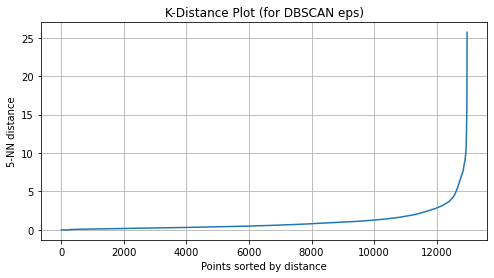

DBSCAN Results — eps=3.0, min_samples=5
→ Clusters found: 69
→ Silhouette Score: 0.079


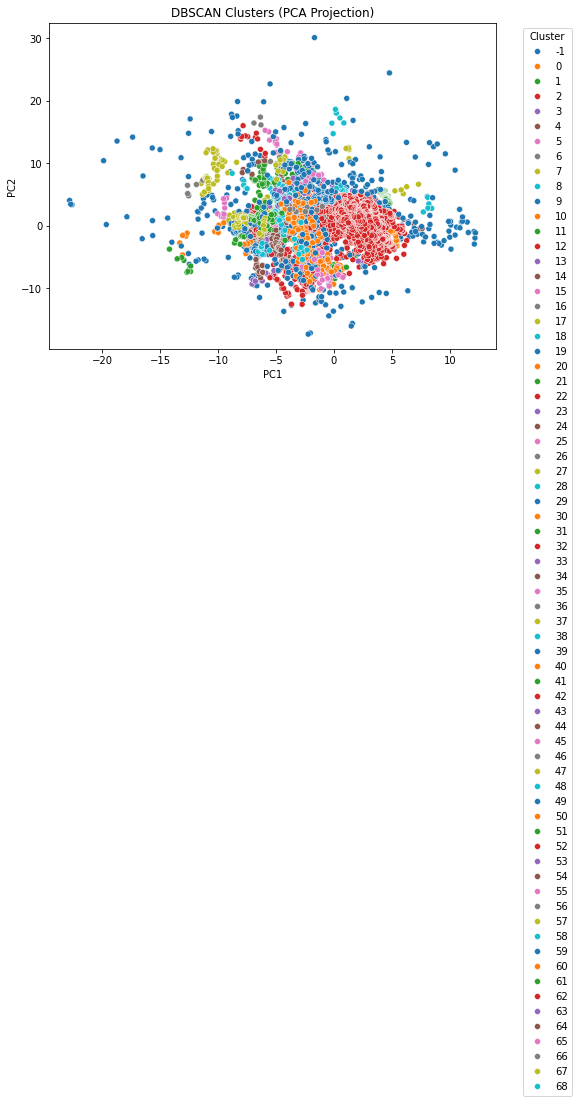

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# ----------------------------------------
# 1. Load and Prepare Data
# ----------------------------------------

def load_and_pivot_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    df = df[df["Joint"] != "Background"]
    df_pivot = df.pivot_table(index=["Patient", "Frame"], columns="Joint", values=["X", "Y"])
    df_pivot.columns = [f"{joint}_{coord}" for coord, joint in df_pivot.columns]
    return df_pivot.reset_index()

# ----------------------------------------
# 2. Normalize Joints to MidHip
# ----------------------------------------

def normalize_to_midhip(df: pd.DataFrame) -> pd.DataFrame:
    df_norm = df.copy()
    joint_names = sorted(set(
        j.split("_")[0] for j in df.columns
        if "_" in j and "MidHip" not in j and not j.startswith(("Patient", "Frame"))
    ))
    for joint in joint_names:
        df_norm[f"{joint}_X"] = df[f"{joint}_X"] - df["MidHip_X"]
        df_norm[f"{joint}_Y"] = df[f"{joint}_Y"] - df["MidHip_Y"]
    return df_norm

# ----------------------------------------
# 3. Feature Engineering
# ----------------------------------------

def add_anatomical_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    df_feat["shoulder_width"] = np.sqrt(
        (df_feat["LShoulder_X"] - df_feat["RShoulder_X"])**2 +
        (df_feat["LShoulder_Y"] - df_feat["RShoulder_Y"])**2
    )
    df_feat["torso_length"] = np.sqrt(
        (df_feat["Neck_X"] - df_feat["MidHip_X"])**2 +
        (df_feat["Neck_Y"] - df_feat["MidHip_Y"])**2
    )
    return df_feat

# ----------------------------------------
# 4. Preprocessing (Imputation + Scaling)
# ----------------------------------------

def preprocess_features(df: pd.DataFrame) -> np.ndarray:
    df_numeric = df.drop(columns=["Patient", "Frame"])
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(df_numeric)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    return X_scaled

# ----------------------------------------
# 5. K-distance Plot (for eps estimation)
# ----------------------------------------

def plot_k_distance(X: np.ndarray, k: int = 5) -> None:
    neighbors = NearestNeighbors(n_neighbors=k)
    distances, _ = neighbors.fit(X).kneighbors(X)
    k_distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.title("K-Distance Plot (for DBSCAN eps)")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-NN distance")
    plt.grid(True)
    plt.show()

# ----------------------------------------
# 6. Run DBSCAN and Evaluate
# ----------------------------------------

def run_dbscan(X: np.ndarray, eps: float = 2.0, min_samples: int = 5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    silhouette = silhouette_score(X, labels) if n_clusters > 1 else -1
    print(f"DBSCAN Results — eps={eps}, min_samples={min_samples}")
    print(f"→ Clusters found: {n_clusters}")
    print(f"→ Silhouette Score: {silhouette:.3f}")
    return labels




# ----------------------------------------
# 7. Visualize with PCA
# ----------------------------------------

def plot_clusters(X: np.ndarray, labels: np.ndarray) -> None:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    df_vis = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_vis["Cluster"] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="Cluster", palette="tab10")
    plt.title("DBSCAN Clusters (PCA Projection)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# 🧪 MAIN EXECUTION
# ----------------------------------------

if __name__ == "__main__":
    # Load and process
    df_wide = load_and_pivot_data("joint_positions.csv")
    df_norm = normalize_to_midhip(df_wide)
    df_feat = add_anatomical_features(df_norm)
    X_scaled = preprocess_features(df_feat)

    # Visualize k-distance plot
    plot_k_distance(X_scaled, k=5)

    # Run DBSCAN
    labels = run_dbscan(X_scaled, eps=3.0, min_samples=5)

    # Visualize results
    plot_clusters(X_scaled, labels)


In [12]:
# df=pd.read_csv('joint_positions.csv')
# df
# df.Joint.unique()


🔝 Best Parameters:
eps             5.000000
min_samples     7.000000
clusters       18.000000
noise_pct       0.025671
silhouette      0.263250
Name: 46, dtype: float64


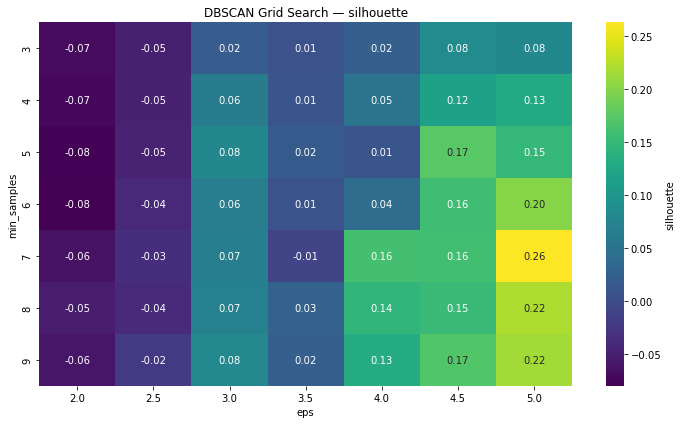

In [21]:
def dbscan_grid_search(X, eps_range, min_samples_range):
    results = []

    for eps, min_samples in itertools.product(eps_range, min_samples_range):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        
        # Skip if all points are noise or one cluster
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        if n_clusters < 2:
            silhouette = -1
        else:
            silhouette = silhouette_score(X, labels)

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "clusters": n_clusters,
            "noise_pct": n_noise / len(labels),
            "silhouette": silhouette
        })

    return pd.DataFrame(results)

def plot_heatmap(df_results, metric='silhouette'):
    heatmap_data = df_results.pivot(index='min_samples', columns='eps', values=metric)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': metric})
    plt.title(f"DBSCAN Grid Search — {metric}")
    plt.xlabel("eps")
    plt.ylabel("min_samples")
    plt.tight_layout()
    plt.show()

# Define parameter ranges
eps_values = np.arange(2.0, 5.1, 0.5)         # try 2.0 to 5.0
min_samples_values = range(3, 10)             # try 3 to 9

# Run search
grid_results = dbscan_grid_search(X_scaled, eps_values, min_samples_values)

# View best result
best = grid_results.sort_values(by="silhouette", ascending=False).iloc[0]
print("\n🔝 Best Parameters:")
print(best)

# Plot Silhouette Score heatmap
plot_heatmap(grid_results, metric="silhouette")

# Optionally: Plot noise percentage or clusters
# plot_heatmap(grid_results, metric="clusters")
# plot_heatmap(grid_results, metric="noise_pct")

DBSCAN Results — eps=5.0, min_samples=7
→ Clusters found: 18
→ Silhouette Score: 0.263


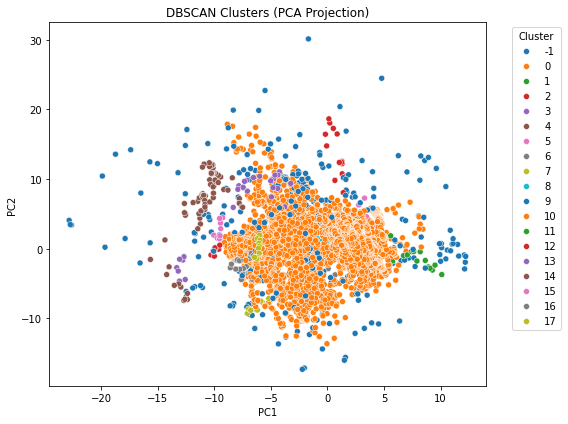

In [22]:
labels = run_dbscan(X_scaled, eps=best['eps'], min_samples=int(best['min_samples']))
plot_clusters(X_scaled, labels)


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


# Check how much variance is retained
explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA Explained Variance: {explained_variance:.2%}")
# Finer grid around the previous best (eps=5.0, min_samples=7)
eps_range = np.arange(4.5, 5.6, 0.2)   # smaller range around best value
min_samples_range = range(6, 9)        # tighter range
              # 5 to 10


idx = np.random.choice(len(X_pca), size=2000, replace=False)  # sample 2k points
X_subset = X_pca[idx]

grid_results_subset = dbscan_grid_search(X_subset, eps_range, min_samples_range)
best_subset = grid_results_subset.sort_values("silhouette", ascending=False).iloc[0]
print(best_subset)


PCA Explained Variance: 90.82%
eps            5.500000
min_samples    6.000000
clusters       2.000000
noise_pct      0.042500
silhouette     0.430137
Name: 15, dtype: float64


DBSCAN Results — eps=5.5, min_samples=6
→ Clusters found: 4
→ Silhouette Score: 0.335
Clusters found: 4
Silhouette Score: 0.33501821332794296


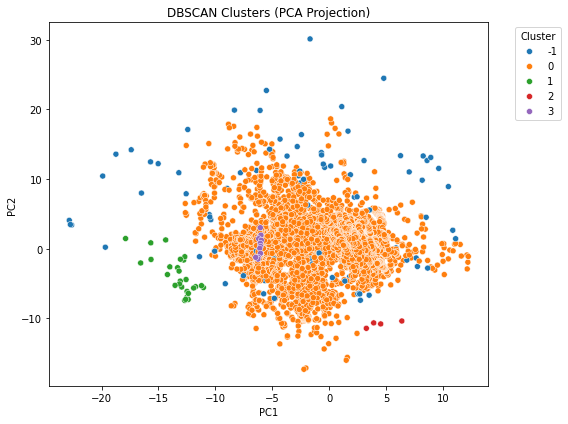

In [28]:
# Slightly smaller eps to split clusters
labels_finer = run_dbscan(X_pca, eps=5.5, min_samples=6)
print("Clusters found:", len(set(labels_finer)) - (1 if -1 in labels_finer else 0))
print("Silhouette Score:", silhouette_score(X_pca, labels_finer))

plot_clusters(X_pca, labels_finer)
